In [ ]:
import pandas as pd

# Read the uploaded CSVs
calendar_df = pd.read_csv("/content/dim_date.csv")
properties_df = pd.read_csv("/content/dim_hotels.csv")
rooms_df = pd.read_csv("/content/dim_hotels.csv")
occupancy_df = pd.read_csv("/content/fact_aggregated_bookings.csv")
bookings_df = pd.read_csv("/content/fact_bookings.csv")


In [ ]:
room_classes_df = pd.DataFrame({
    'room_id': ['RT1', 'RT2', 'RT3', 'RT4'],
    'room_class': ['Standard', 'Elite', 'Premium', 'Presidential']
})

In [ ]:
# Convert dates with specific formats
calendar_df['date'] = pd.to_datetime(calendar_df['date'], format='%d-%b-%y')
bookings_df['check_in_date'] = pd.to_datetime(bookings_df['check_in_date'], format='%Y-%m-%d')
bookings_df['checkout_date'] = pd.to_datetime(bookings_df['checkout_date'], format='%Y-%m-%d')
occupancy_df['check_in_date'] = pd.to_datetime(occupancy_df['check_in_date'], format='%d-%b-%y')


In [ ]:
# Normalize column names
bookings_df.rename(columns={'room_category': 'room_id'}, inplace=True)
occupancy_df.rename(columns={'room_category': 'room_id'}, inplace=True)



In [ ]:
#Bookings + Calendar
merged_df = bookings_df.merge(calendar_df, left_on='check_in_date', right_on='date', how='left')

#Add property info
merged_df = merged_df.merge(rooms_df, on='property_id', how='left')

#Add room class
merged_df = merged_df.merge(room_classes_df, on='room_id', how='left')

#Add occupancy info
merged_df = merged_df.merge(occupancy_df[['property_id', 'check_in_date', 'room_id', 'capacity', 'successful_bookings']],
                            on=['property_id', 'check_in_date', 'room_id'], how='left')


In [ ]:
merged_df.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_id,booking_platform,ratings_given,booking_status,...,date,mmm yy,week no,day_type,property_name,category,city,room_class,capacity,successful_bookings
0,May012216558RT11,16558,2022-04-27,2022-05-01,2022-05-02,3,RT1,direct online,1.0,Checked Out,...,2022-05-01,May 22,W 19,weekend,Atliq Grands,Luxury,Delhi,Standard,19,18
1,May012216558RT12,16558,2022-04-30,2022-05-01,2022-05-02,2,RT1,others,NaN,Cancelled,...,2022-05-01,May 22,W 19,weekend,Atliq Grands,Luxury,Delhi,Standard,19,18
2,May012216558RT13,16558,2022-04-28,2022-05-01,2022-05-04,2,RT1,logtrip,5.0,Checked Out,...,2022-05-01,May 22,W 19,weekend,Atliq Grands,Luxury,Delhi,Standard,19,18
3,May012216558RT14,16558,2022-04-28,2022-05-01,2022-05-02,2,RT1,others,NaN,Cancelled,...,2022-05-01,May 22,W 19,weekend,Atliq Grands,Luxury,Delhi,Standard,19,18
4,May012216558RT15,16558,2022-04-27,2022-05-01,2022-05-02,4,RT1,direct online,5.0,Checked Out,...,2022-05-01,May 22,W 19,weekend,Atliq Grands,Luxury,Delhi,Standard,19,18


In [ ]:
merged_df['occupancy_rate'] = merged_df['successful_bookings'] / merged_df['capacity']


In [ ]:
merged_df['revenue_leakage'] = merged_df['revenue_generated'] - merged_df['revenue_realized']


In [ ]:
merged_df['stay_length'] = (merged_df['checkout_date'] - merged_df['check_in_date']).dt.days


In [ ]:
merged_df['is_weekend'] = merged_df['day_type'].apply(lambda x: 1 if x.lower() == 'weekend' else 0)


<Axes: title={'center': 'Revenue Leakage by Booking Status'}, xlabel='booking_status'>

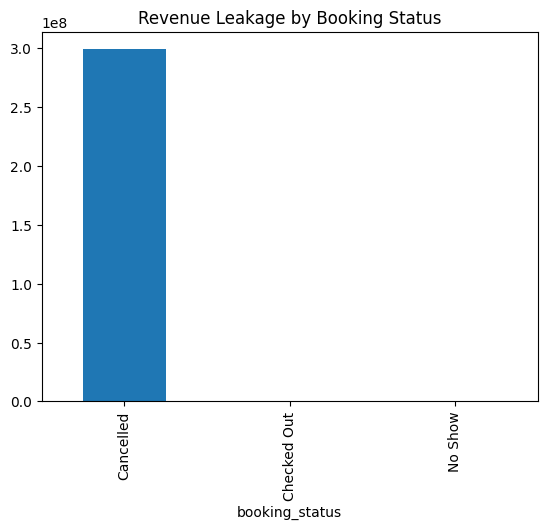

In [ ]:
merged_df.groupby('booking_status')['revenue_leakage'].sum().plot(kind='bar', title='Revenue Leakage by Booking Status')


<Axes: title={'center': 'Revenue by City'}, ylabel='city'>

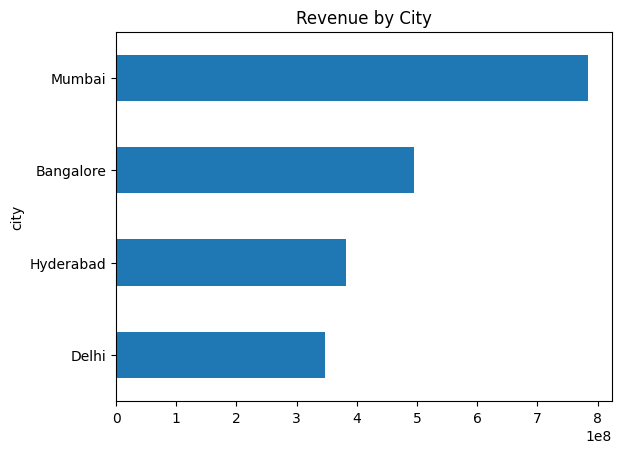

In [ ]:
merged_df.groupby('city')['revenue_generated'].sum().sort_values().plot(kind='barh', title='Revenue by City')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


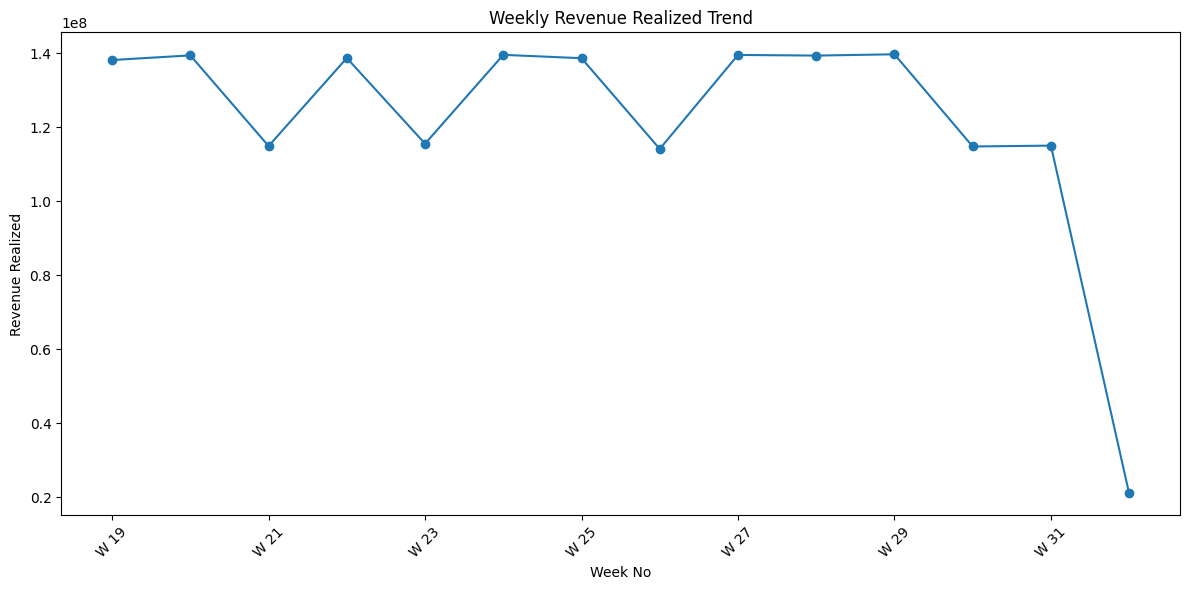

In [ ]:
#Weekly Revenue Trends
plt.figure(figsize=(12, 6))
merged_df.groupby("week no")["revenue_realized"].sum().plot(marker='o')
plt.title("Weekly Revenue Realized Trend")
plt.ylabel("Revenue Realized")
plt.xlabel("Week No")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

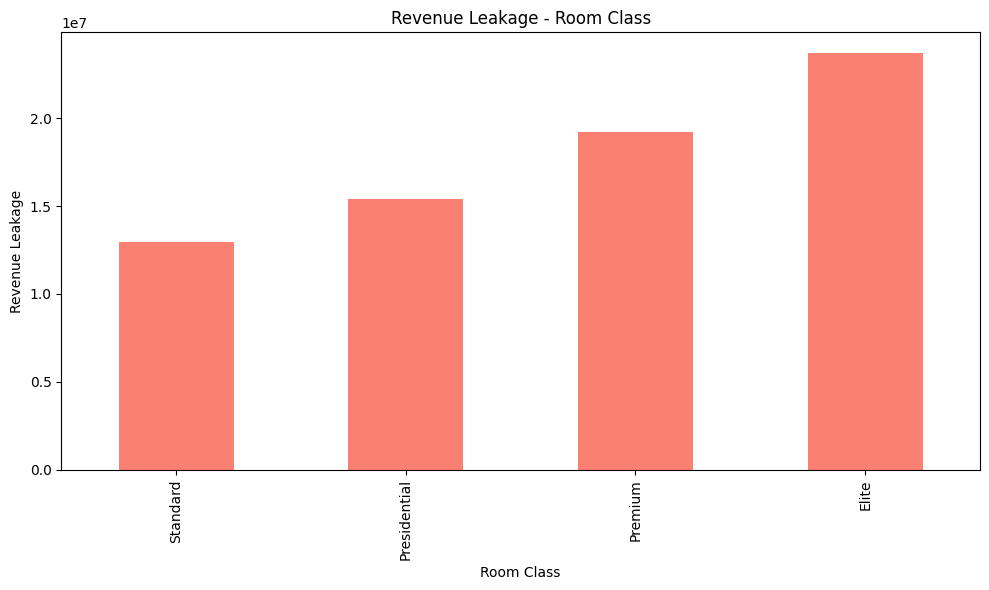

In [ ]:
#Revenue Leakage by Room Class
plt.figure(figsize=(10, 6))
merged_df.groupby("room_class")["revenue_leakage"].sum().sort_values().plot(kind="bar", color='salmon')
plt.title("Revenue Leakage - Room Class")
plt.ylabel("Revenue Leakage")
plt.xlabel("Room Class")
plt.tight_layout()
plt.show()

In [ ]:
filtered_df = merged_df[merged_df['capacity'] > 0].copy()
filtered_df['revpar'] = filtered_df['revenue_realized'] / filtered_df['capacity']


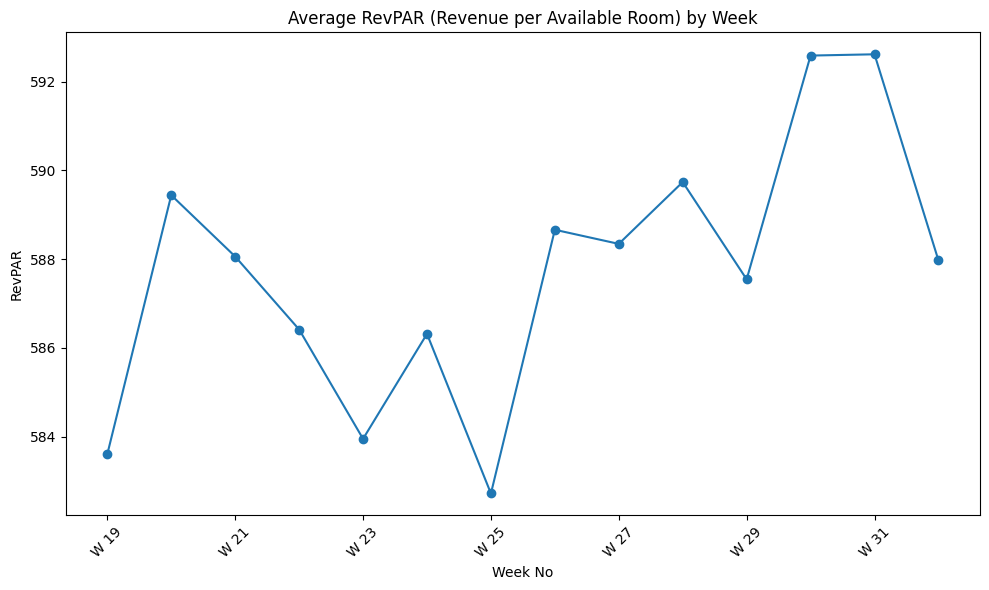

In [ ]:
#Average RevPAR per Week
plt.figure(figsize=(10, 6))
filtered_df.groupby("week no")["revpar"].mean().plot(marker='o')
plt.title("Average RevPAR (Revenue per Available Room) by Week")
plt.xlabel("Week No")
plt.ylabel("RevPAR")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


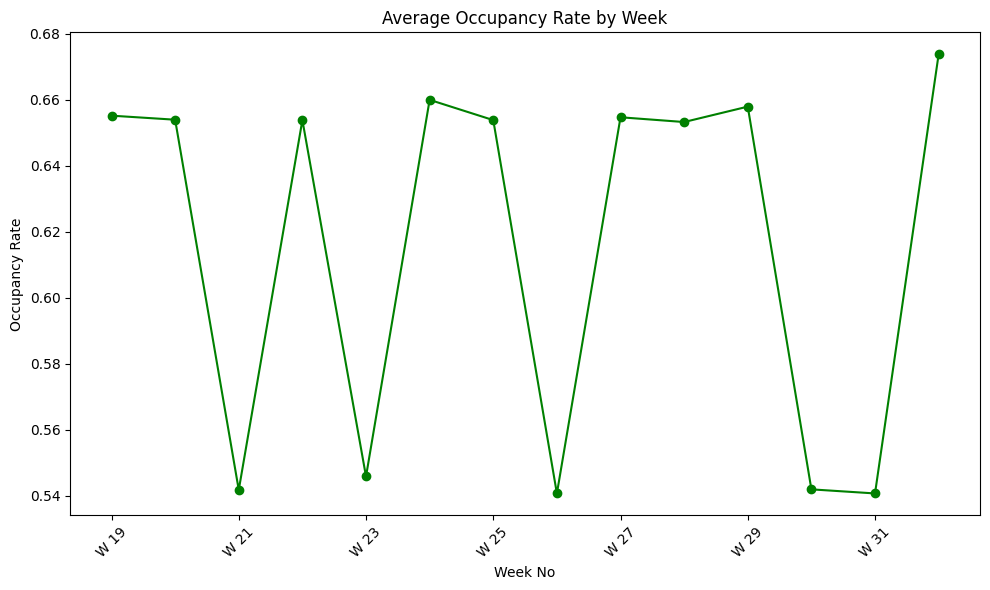

In [ ]:
#Average Occupancy % by Week
plt.figure(figsize=(10, 6))
filtered_df.groupby("week no")["occupancy_rate"].mean().plot(marker='o', color='green')
plt.title("Average Occupancy Rate by Week")
plt.xlabel("Week No")
plt.ylabel("Occupancy Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

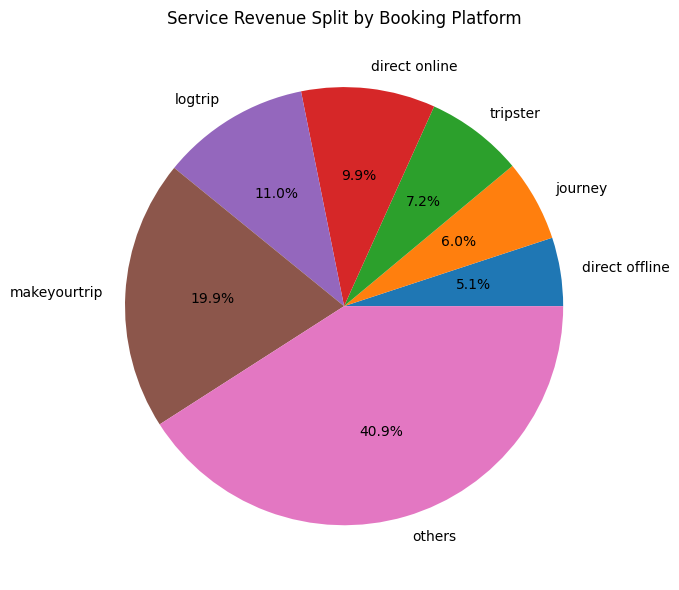

In [ ]:

plt.figure(figsize=(10, 6))
merged_df.groupby("booking_platform")["revenue_realized"].sum().sort_values().plot(kind='pie', autopct='%1.1f%%')
plt.title("Service Revenue Split by Booking Platform")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [ ]:

valid_df = merged_df[merged_df['capacity'] > 0].copy()
valid_df['revpar'] = valid_df['revenue_realized'] / valid_df['capacity']
valid_df['occupancy_rate'] = valid_df['successful_bookings'] / valid_df['capacity']
valid_df['revenue_leakage'] = valid_df['revenue_generated'] - valid_df['revenue_realized']


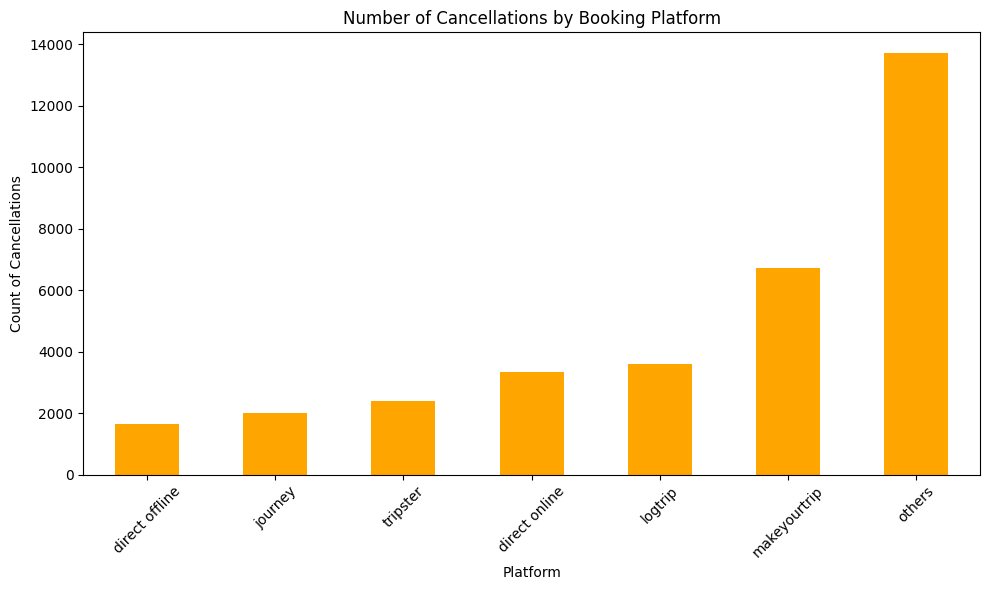

In [ ]:
import matplotlib.pyplot as plt

#Cancellations vs Platform
plt.figure(figsize=(10, 6))
cancelled = valid_df[valid_df['booking_status'].str.lower() == 'cancelled']
cancelled.groupby('booking_platform')['booking_id'].count().sort_values().plot(kind='bar', color='orange')
plt.title("Number of Cancellations by Booking Platform")
plt.ylabel("Count of Cancellations")
plt.xlabel("Platform")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

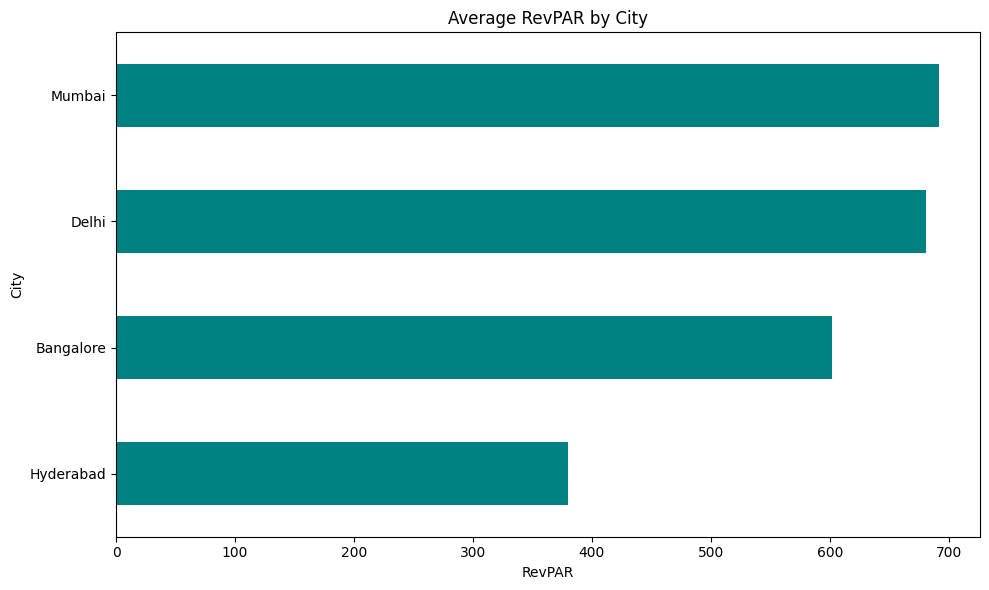

In [ ]:
#City-wise RevPAR
plt.figure(figsize=(10, 6))
valid_df.groupby('city')['revpar'].mean().sort_values().plot(kind='barh', color='teal')
plt.title("Average RevPAR by City")
plt.xlabel("RevPAR")
plt.ylabel("City")
plt.tight_layout()
plt.show()


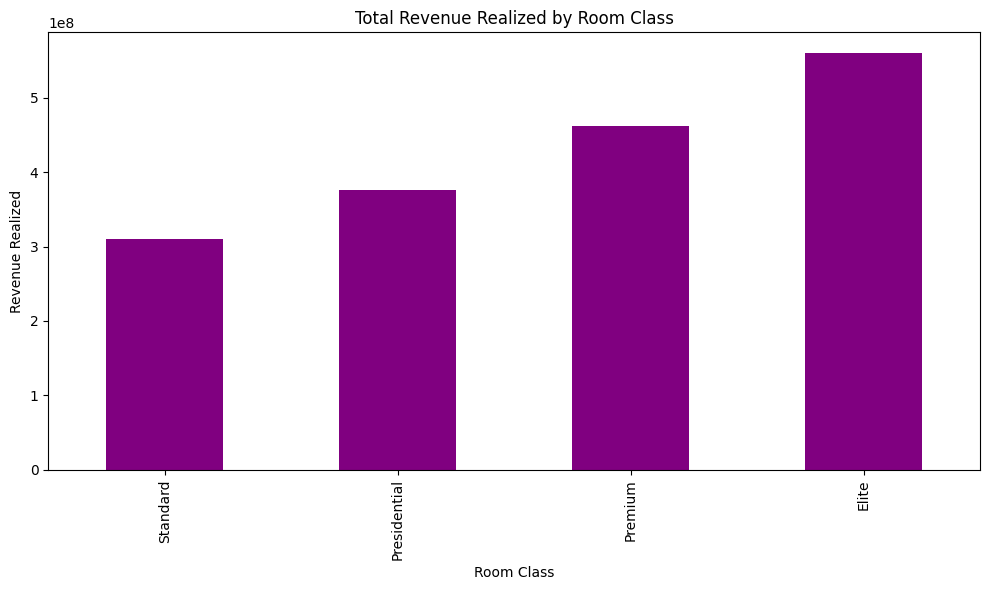

In [ ]:
#Room-class Profitability
plt.figure(figsize=(10, 6))
valid_df.groupby('room_class')['revenue_realized'].sum().sort_values().plot(kind='bar', color='purple')
plt.title("Total Revenue Realized by Room Class")
plt.ylabel("Revenue Realized")
plt.xlabel("Room Class")
plt.tight_layout()
plt.show()

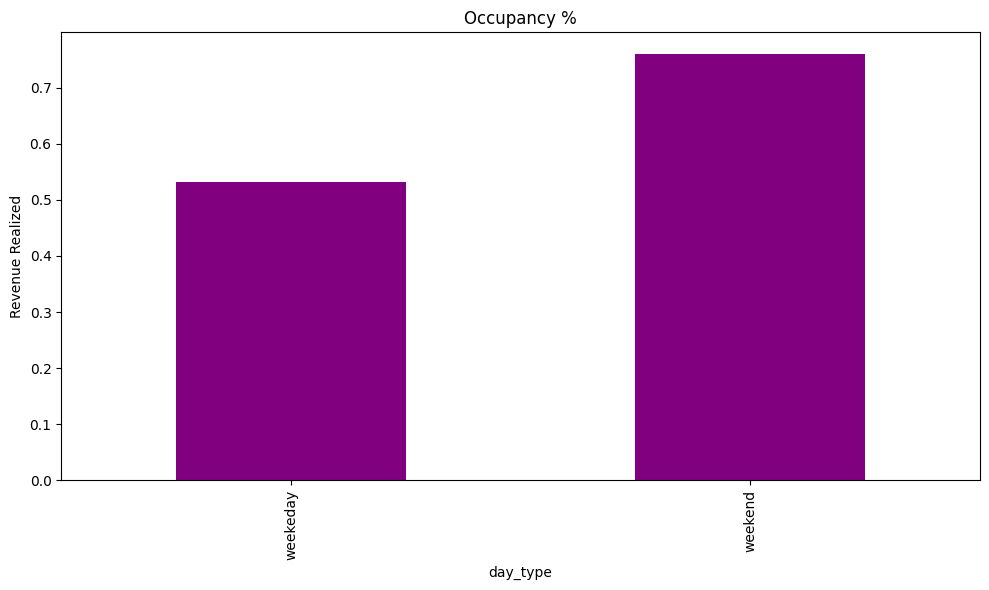

In [ ]:
#Weekend and Week day analysis
plt.figure(figsize=(10, 6))
valid_df.groupby('day_type')['occupancy_rate'].mean().sort_values().plot(kind='bar', color='purple')
plt.title("Occupancy %")
plt.ylabel("occupancy_rate")
plt.tight_layout()
plt.show()

In [ ]:
merged_df.to_csv('output.csv', index=False)